<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/gula_pasir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7f1288503670>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.gula_pasir.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


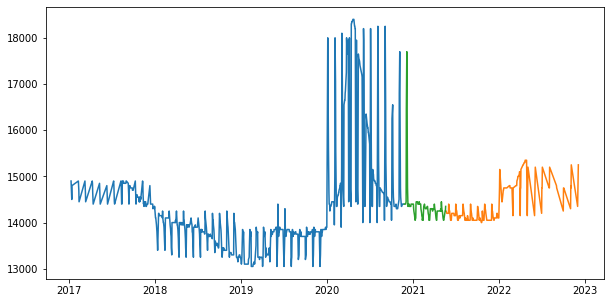

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_gulpas_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [11]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [12]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 20s 48ms/step - loss: 0.2206 - mae: 0.3900 - mape: 82.8516 - val_loss: 0.0016 - val_mae: 0.0331 - val_mape: 9090946.0000
Epoch 2/30
44/44 [==============================] - 1s 22ms/step - loss: 0.1509 - mae: 0.2886 - mape: 53.5454 - val_loss: 0.0123 - val_mae: 0.1080 - val_mape: 17416676.0000
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1114 - mae: 0.2169 - mape: 34.3048 - val_loss: 0.0274 - val_mae: 0.1634 - val_mape: 23415388.0000
Epoch 4/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0898 - mae: 0.1917 - mape: 31.1543 - val_loss: 0.0439 - val_mae: 0.2078 - val_mape: 28216942.0000
Epoch 5/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0776 - mae: 0.1880 - mape: 34.3300 - val_loss: 0.0584 - val_mae: 0.2402 - val_mape: 31722386.0000
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0711 - mae: 0.1930 - mape: 39.3081 - val_loss: 0.0701 - val_

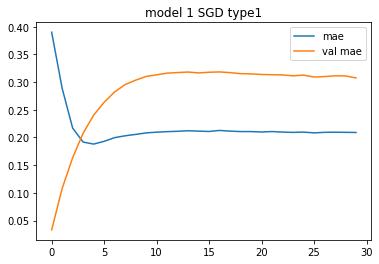

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
830.59503 5.8447323 899.0378190042953


,date,actual,prediction
0,2021-05-20,14250,15294.926758
1,2021-05-21,14250,15295.284180
2,2021-05-24,14200,15285.803711
3,2021-05-25,14200,15283.880859
4,2021-05-27,14200,15275.162109
...,...,...,...
229,2022-11-02,14800,15320.245117
230,2022-11-03,14750,15323.342773
231,2022-11-04,15250,15313.347656
232,2022-12-01,14350,15317.274414


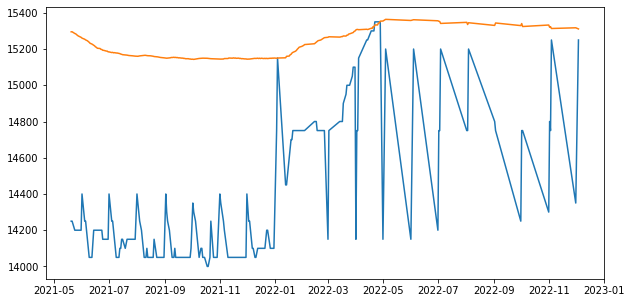

In [15]:
prediction = forecast_predict(model, test_gulpas_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_gulpas = pd.DataFrame()
data_new_gulpas['date'] = y_test
data_new_gulpas['actual'] = x_test
data_new_gulpas['prediction'] = data_result
data_new_gulpas.to_csv('gulpas_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_gulpas.date, data_new_gulpas.actual)
plt.plot(data_new_gulpas.date, data_new_gulpas.prediction)
data_new_gulpas

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0345 - mae: 0.1221 - mape: 2808199.0000 - val_loss: 0.0486 - val_mae: 0.2188 - val_mape: 29436084.0000
Epoch 2/30
718/718 [==============================] - 8s 11ms/step - loss: 0.0293 - mae: 0.1062 - mape: 2064873.5000 - val_loss: 0.0491 - val_mae: 0.2200 - val_mape: 29571428.0000
Epoch 3/30
718/718 [==============================] - 6s 9ms/step - loss: 0.0287 - mae: 0.1067 - mape: 2231194.0000 - val_loss: 0.0432 - val_mae: 0.2063 - val_mape: 28103340.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0274 - mae: 0.1043 - mape: 2145434.0000 - val_loss: 0.0432 - val_mae: 0.2062 - val_mape: 28104470.0000
Epoch 5/30
718/718 [==============================] - 7s 9ms/step - loss: 0.0267 - mae: 0.1034 - mape: 2360759.2500 - val_loss: 0.0330 - val_mae: 0.1798 - val_mape: 25255870.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0253 - mae: 0.1006 - mape: 2

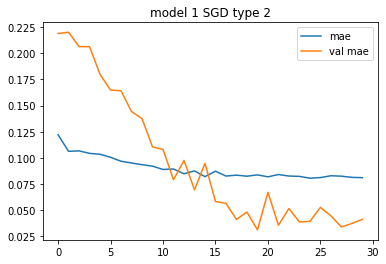

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
235.07169 1.6323553 283.5769709223582


,date,actual,prediction
0,2021-05-20,14250,15294.926758
1,2021-05-21,14250,15295.284180
2,2021-05-24,14200,15285.803711
3,2021-05-25,14200,15283.880859
4,2021-05-27,14200,15275.162109
...,...,...,...
229,2022-11-02,14800,15320.245117
230,2022-11-03,14750,15323.342773
231,2022-11-04,15250,15313.347656
232,2022-12-01,14350,15317.274414


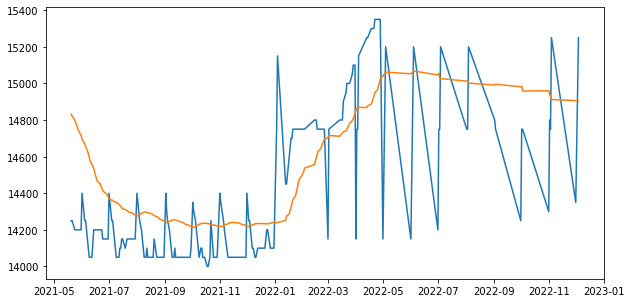

In [18]:
win_size1 = 60
test_gulpas_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_gulpas_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_gulpas_1 = pd.DataFrame()
data_new_gulpas_1['actual'] = x_test
data_new_gulpas_1['prediction'] = data_result_1
data_new_gulpas_1.to_csv('gulpas_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas_1.actual)
plt.plot(y_test, data_new_gulpas_1.prediction)
data_new_gulpas

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0299 - mae: 0.1061 - mape: 2058971.7500 - val_loss: 0.0023 - val_mae: 0.0414 - val_mape: 10215126.0000
Epoch 2/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0298 - mae: 0.1103 - mape: 2177688.5000 - val_loss: 0.0026 - val_mae: 0.0448 - val_mape: 10611700.0000
Epoch 3/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0298 - mae: 0.1089 - mape: 2129469.0000 - val_loss: 0.0025 - val_mae: 0.0433 - val_mape: 10443501.0000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0298 - mae: 0.1092 - mape: 2152653.7500 - val_loss: 0.0022 - val_mae: 0.0402 - val_mape: 10069441.0000
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0297 - mae: 0.1086 - mape: 2120609.7500 - val_loss: 0.0023 - val_mae: 0.0410 - val_mape: 10167685.0000
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0297 - mae: 0.1086 - mape: 2123000.

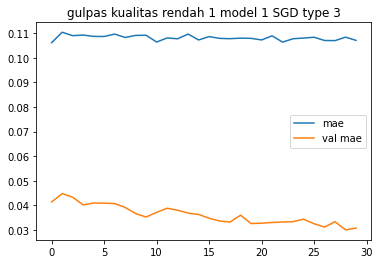

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('gulpas kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
233.8817 1.6265815 288.6347307800986


,actual,prediction
0,14250,14874.840820
1,14250,14863.564453
2,14200,14839.621094
3,14200,14822.937500
4,14200,14796.853516
...,...,...
229,14800,14987.984375
230,14750,14977.327148
231,15250,14959.885742
232,14350,14952.702148


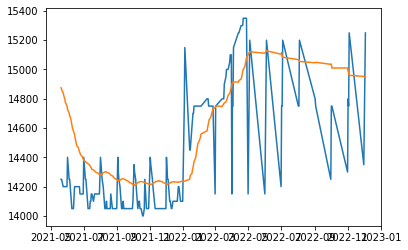

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_gulpas_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_gulpas_2 = pd.DataFrame()
# data_new_gulpas1['date'] = date_test
data_new_gulpas_2['actual'] = x_test
data_new_gulpas_2['prediction'] = data_result_2
data_new_gulpas_2.to_csv('gulpas_model1_sgd_type3')

plt.plot(y_test, data_new_gulpas_2.actual)
plt.plot(y_test, data_new_gulpas_2.prediction)
data_new_gulpas_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 37ms/step - loss: 0.2633 - mae: 0.4389 - mape: 96.4727 - val_loss: 0.0012 - val_mae: 0.0315 - val_mape: 3171371.2500
Epoch 2/30
44/44 [==============================] - 1s 20ms/step - loss: 0.1928 - mae: 0.3523 - mape: 72.0050 - val_loss: 0.0017 - val_mae: 0.0348 - val_mape: 9274512.0000
Epoch 3/30
44/44 [==============================] - 1s 19ms/step - loss: 0.1002 - mae: 0.2146 - mape: 38.5119 - val_loss: 0.0201 - val_mae: 0.1394 - val_mape: 20783006.0000
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0624 - mae: 0.2070 - mape: 52.5518 - val_loss: 0.0247 - val_mae: 0.1552 - val_mape: 22487750.0000
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0613 - mae: 0.2031 - mape: 50.8671 - val_loss: 0.0255 - val_mae: 0.1577 - val_mape: 22769838.0000
Epoch 6/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0603 - mae: 0.1973 - mape: 47.9350 - val_loss: 0.0237 - val_ma

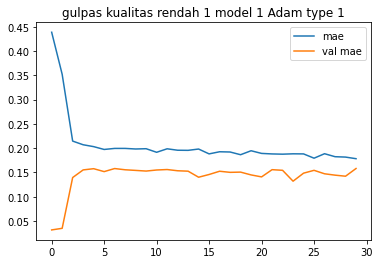

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('gulpas kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
555.3636 3.8996274 605.1019283971916


,actual,prediction
0,14250,15159.076172
1,14250,15121.685547
2,14200,15136.406250
3,14200,15098.025391
4,14200,15104.416992
...,...,...
229,14800,15366.106445
230,14750,15282.548828
231,15250,15330.335938
232,14350,15253.040039


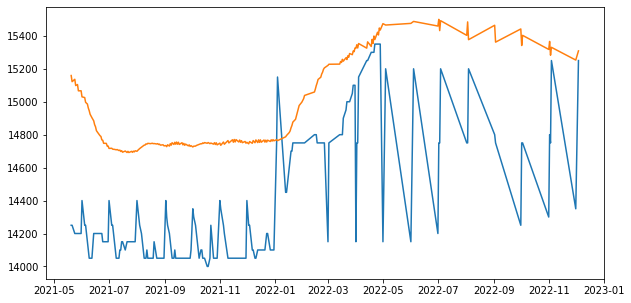

In [25]:
prediction_a = forecast_predict(model_a, test_gulpas_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_gulpas_a = pd.DataFrame()
# data_new_gulpas1['date'] = date_test
data_new_gulpas_a['actual'] = x_test
data_new_gulpas_a['prediction'] = data_result_a
data_new_gulpas_a.to_csv('gulpas_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_gulpas_a.actual)
plt.plot(y_test, data_new_gulpas_a.prediction)
data_new_gulpas_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0184 - mae: 0.0851 - mape: 2054443.6250 - val_loss: 0.0043 - val_mae: 0.0598 - val_mape: 12488808.0000
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0179 - mae: 0.0780 - mape: 1615296.8750 - val_loss: 0.0048 - val_mae: 0.0638 - val_mape: 12883902.0000
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0175 - mae: 0.0763 - mape: 1615703.8750 - val_loss: 0.0040 - val_mae: 0.0570 - val_mape: 12165594.0000
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0178 - mae: 0.0772 - mape: 1540263.7500 - val_loss: 0.0037 - val_mae: 0.0544 - val_mape: 11865349.0000
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0173 - mae: 0.0764 - mape: 1638418.0000 - val_loss: 0.0018 - val_mae: 0.0353 - val_mape: 9557112.0000
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0173 - mae: 0.0770 - mape: 144

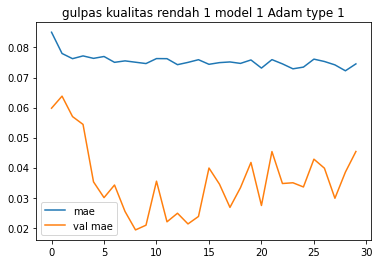

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('gulpas kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
614.9557 4.275458 756.1854517907627


,actual,prediction
0,14250,15757.299805
1,14250,15711.150391
2,14200,15736.272461
3,14200,15686.217773
4,14200,15699.043945
...,...,...
229,14800,16255.937500
230,14750,16146.509766
231,15250,16214.411133
232,14350,16098.604492


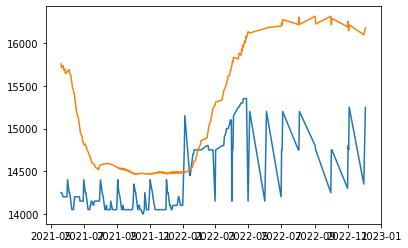

In [28]:
prediction_a1 = forecast_predict(model_a, test_gulpas_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_gulpas_a1 = pd.DataFrame()
data_new_gulpas_a1['actual'] = x_test
data_new_gulpas_a1['prediction'] = data_result_a1
data_new_gulpas_a1.to_csv('gulpas_model1_adam_type2.csv')

plt.plot(y_test, data_new_gulpas_a1.actual)
plt.plot(y_test, data_new_gulpas_a1.prediction)
data_new_gulpas_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0244 - mae: 0.0963 - mape: 2144526.7500 - val_loss: 0.0016 - val_mae: 0.0321 - val_mape: 9013676.0000
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0240 - mae: 0.0929 - mape: 1905057.2500 - val_loss: 0.0013 - val_mae: 0.0284 - val_mape: 8458896.0000
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0239 - mae: 0.0942 - mape: 1923308.2500 - val_loss: 0.0012 - val_mae: 0.0278 - val_mape: 8365545.5000
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0240 - mae: 0.0941 - mape: 1851173.3750 - val_loss: 0.0013 - val_mae: 0.0278 - val_mape: 8368224.0000
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0242 - mae: 0.0953 - mape: 1909810.8750 - val_loss: 0.0013 - val_mae: 0.0281 - val_mape: 8405485.0000
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0240 - mae: 0.0949 - mape: 1851855.5000 

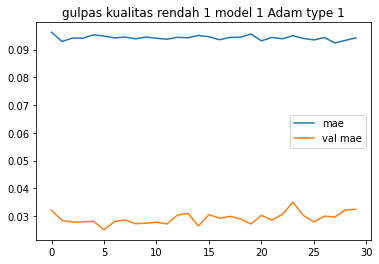

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('gulpas kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
350.39285 2.4136808 521.8736377227729


,actual,prediction
0,14250,14662.411133
1,14250,14652.553711
2,14200,14676.693359
3,14200,14665.288086
4,14200,14687.081055
...,...,...
229,14800,16020.981445
230,14750,15896.179688
231,15250,15935.109375
232,14350,15806.164062


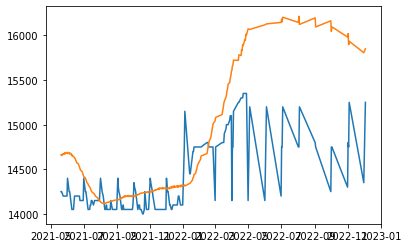

In [31]:
prediction_a2 = forecast_predict(model_a, test_gulpas_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_gulpas_a2 = pd.DataFrame()
# data_new_gulpas1['date'] = date_test
data_new_gulpas_a2['actual'] = x_test
data_new_gulpas_a2['prediction'] = data_result_a2
data_new_gulpas_a2.to_csv('gulpas_model1_adam_type3.csv')

plt.plot(y_test, data_new_gulpas_a2.actual)
plt.plot(y_test, data_new_gulpas_a2.prediction)
data_new_gulpas_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.1999 - mae: 0.3534 - mape: 71.9062 - val_loss: 0.0019 - val_mae: 0.0374 - val_mape: 9557246.0000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0787 - mae: 0.2201 - mape: 50.7698 - val_loss: 0.0122 - val_mae: 0.1077 - val_mape: 17220794.0000
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0629 - mae: 0.2050 - mape: 51.4813 - val_loss: 0.0111 - val_mae: 0.1024 - val_mape: 16710127.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0637 - mae: 0.2052 - mape: 50.7292 - val_loss: 0.0124 - val_mae: 0.1082 - val_mape: 17371270.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0600 - mae: 0.1926 - mape: 45.7764 - val_loss: 0.0205 - val_mae: 0.1410 - val_mape: 20925880.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0586 - mae: 0.1975 - mape: 48.7299 - val_loss: 0.0152 - val_m

17/17 [==============================] - 0s 7ms/step - loss: 0.0624 - mae: 0.2005 - mape: 67.8240


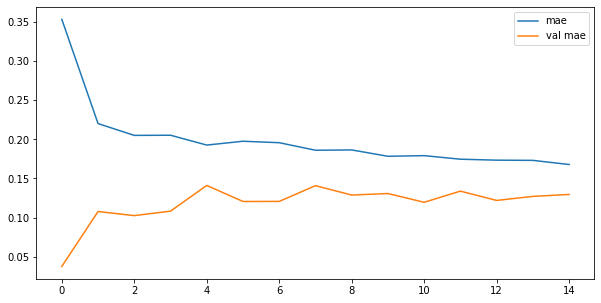

In [34]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [35]:
prediction1 = forecast_predict(model1, test_gulpas_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_gulpas1 = pd.DataFrame()
data_new_gulpas1['actual'] = x_test
data_new_gulpas1['prediction'] = data_result1
data_new_gulpas1.to_csv('gulpas_model2_adam_type1.csv')

data_new_gulpas1

131/131 [==============================] - 2s 8ms/step
552.00696 3.8613493 598.3066469211252


,actual,prediction
0,14250,14924.662109
1,14250,14908.180664
2,14200,14927.584961
3,14200,14906.918945
4,14200,14923.184570
...,...,...
229,14800,15559.260742
230,14750,15470.823242
231,15250,15513.720703
232,14350,15428.413086


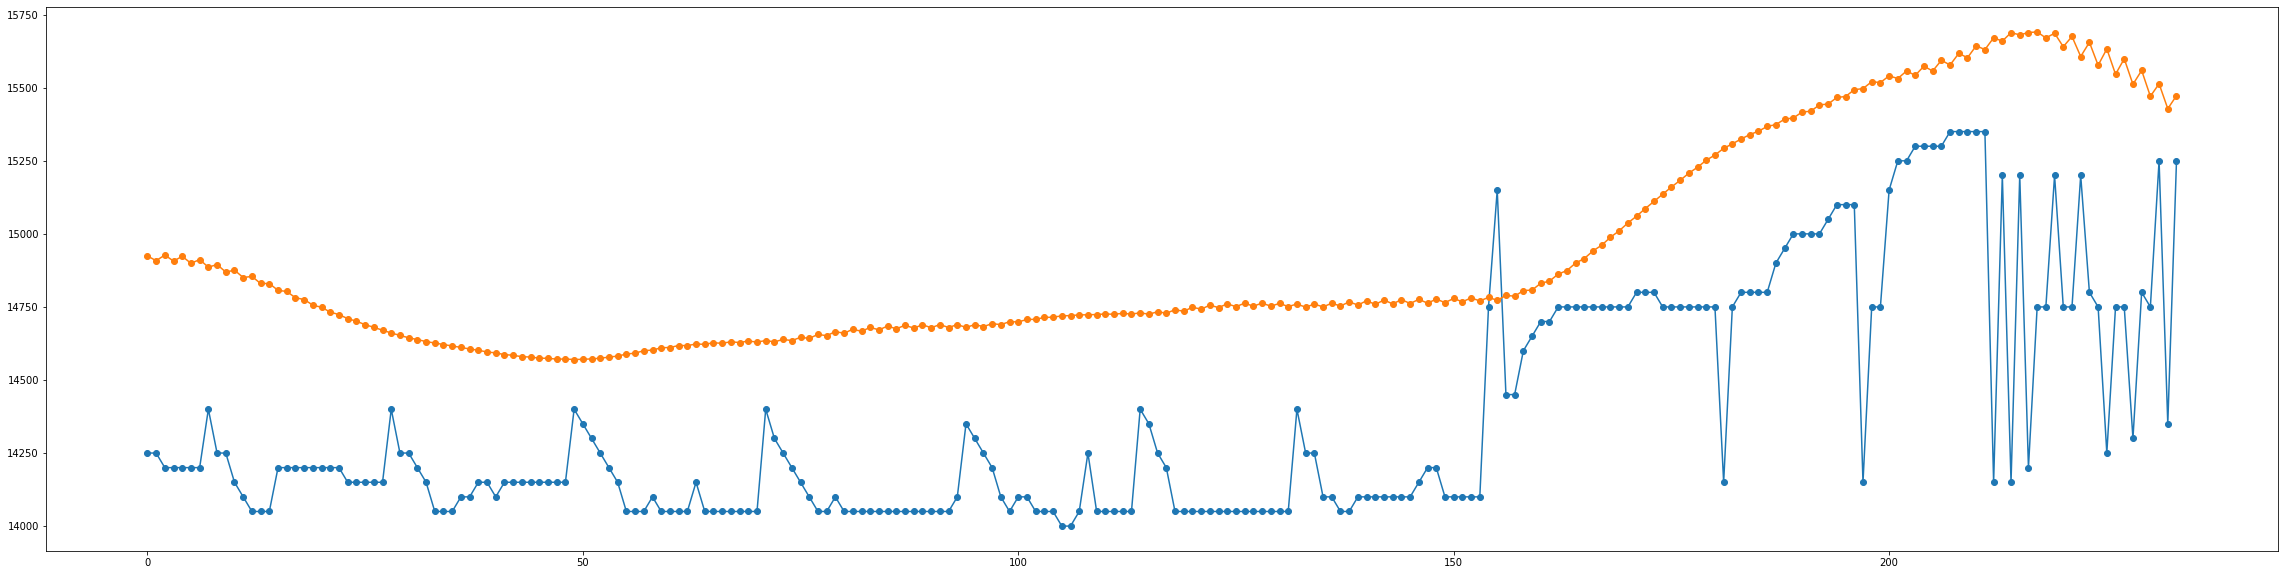

In [36]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_gulpas1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_gulpas1['prediction'], '-o')

#### Type 2

In [37]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0185 - mae: 0.0826 - mape: 1926690.3750 - val_loss: 0.0076 - val_mae: 0.0828 - val_mape: 14880811.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0171 - mae: 0.0776 - mape: 1579401.5000 - val_loss: 0.0026 - val_mae: 0.0449 - val_mape: 10671059.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0173 - mae: 0.0778 - mape: 1580492.8750 - val_loss: 0.0011 - val_mae: 0.0257 - val_mape: 8108626.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0173 - mae: 0.0776 - mape: 1587914.7500 - val_loss: 0.0011 - val_mae: 0.0257 - val_mape: 7996539.0000
Epoch 5/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0168 - mae: 0.0761 - mape: 1456862.8750 - val_loss: 0.0021 - val_mae: 0.0383 - val_mape: 9941279.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0165 - mae: 0.0743 - mape: 1515

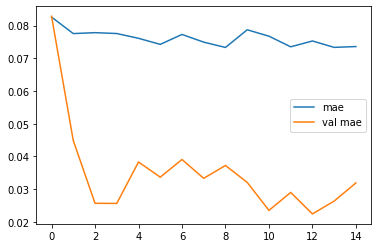

In [38]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
419.1938 2.9134743 598.3066469211252


,actual,prediction
0,14250,15663.515625
1,14250,15651.549805
2,14200,15652.609375
3,14200,15635.032227
4,14200,15640.575195
...,...,...
229,14800,16056.010742
230,14750,16033.392578
231,15250,16051.816406
232,14350,16027.685547


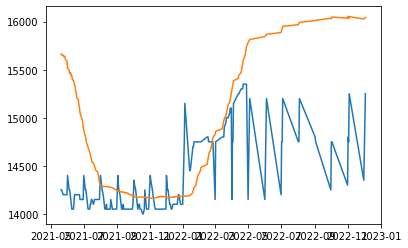

In [39]:
prediction1_1 = forecast_predict(model1, test_gulpas_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_gulpas1_1 = pd.DataFrame()
data_new_gulpas1_1['actual'] = x_test
data_new_gulpas1_1['prediction'] = data_result1_1
data_new_gulpas1_1.to_csv('gulpas_model2_adam_type2.csv')

plt.plot(y_test, data_new_gulpas1_1.actual)
plt.plot(y_test, data_new_gulpas1_1.prediction)
data_new_gulpas1_1

#### Type 3

In [40]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0255 - mae: 0.1028 - mape: 1656017.0000 - val_loss: 0.0018 - val_mae: 0.0351 - val_mape: 9253912.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0245 - mae: 0.0993 - mape: 1899846.6250 - val_loss: 0.0018 - val_mae: 0.0359 - val_mape: 9372814.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0245 - mae: 0.0964 - mape: 1839716.6250 - val_loss: 0.0019 - val_mae: 0.0366 - val_mape: 9497147.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0239 - mae: 0.0958 - mape: 1922466.0000 - val_loss: 0.0016 - val_mae: 0.0332 - val_mape: 9034442.0000
Epoch 5/15
84/84 [==============================] - 1s 15ms/step - loss: 0.0240 - mae: 0.0944 - mape: 1938467.6250 - val_loss: 0.0016 - val_mae: 0.0327 - val_mape: 8986595.0000
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0241 - mae: 0.0953 - mape: 1901773.5000 

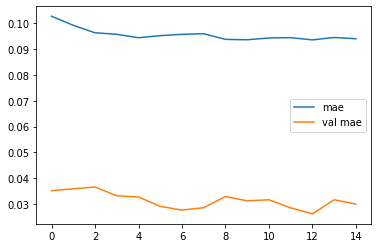

In [41]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
308.03906 2.118369 598.3066469211252


,actual,prediction
0,14250,14656.416992
1,14250,14650.007812
2,14200,14670.551758
3,14200,14657.923828
4,14200,14676.783203
...,...,...
229,14800,16145.939453
230,14750,16094.054688
231,15250,16084.247070
232,14350,16028.025391


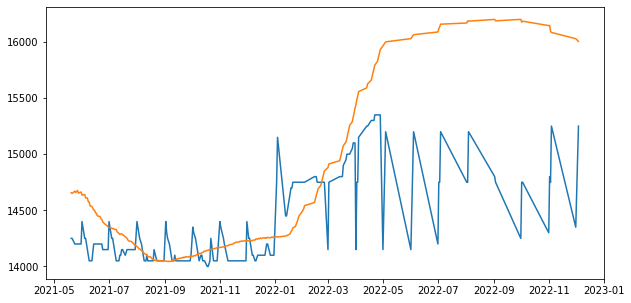

In [42]:
prediction1_2 = forecast_predict(model1, test_gulpas_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_gulpas1_2 = pd.DataFrame()
data_new_gulpas1_2['actual'] = x_test
data_new_gulpas1_2['prediction'] = data_result1_2
data_new_gulpas1_2.to_csv('gulpas_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas1_2.actual)
plt.plot(y_test, data_new_gulpas1_2.prediction)

data_new_gulpas1_2

### SGD

In [43]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [44]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [45]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.2513 - mae: 0.4260 - mape: 92.9293 - val_loss: 6.5680e-04 - val_mae: 0.0179 - val_mape: 5633970.5000
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1958 - mae: 0.3563 - mape: 72.8028 - val_loss: 0.0040 - val_mae: 0.0577 - val_mape: 11943151.0000
Epoch 3/15
44/44 [==============================] - 1s 21ms/step - loss: 0.1542 - mae: 0.2928 - mape: 54.5274 - val_loss: 0.0132 - val_mae: 0.1118 - val_mape: 17794660.0000
Epoch 4/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1247 - mae: 0.2409 - mape: 40.3034 - val_loss: 0.0252 - val_mae: 0.1568 - val_mape: 22663830.0000
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1043 - mae: 0.2050 - mape: 31.6438 - val_loss: 0.0382 - val_mae: 0.1938 - val_mape: 26662916.0000
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0912 - mae: 0.1936 - mape: 31.6907 - val_loss: 0.0522 - v

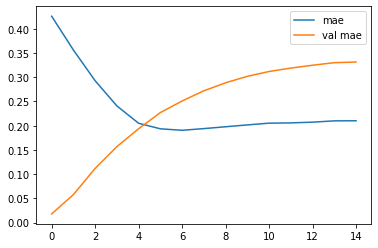

In [46]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
856.709 6.0299416 929.4155421553913


,actual,prediction
0,14250,15281.957031
1,14250,15277.335938
2,14200,15276.835938
3,14200,15271.840820
4,14200,15270.967773
...,...,...
229,14800,15298.334961
230,14750,15289.651367
231,15250,15294.188477
232,14350,15286.781250


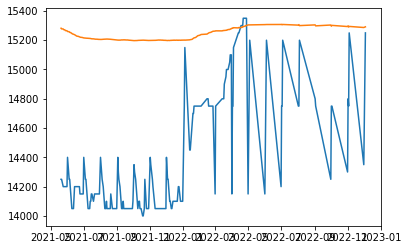

In [47]:
prediction1_a = forecast_predict(model1_a, test_gulpas_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_gulpas1_a = pd.DataFrame()
data_new_gulpas1_a['actual'] = x_test
data_new_gulpas1_a['prediction'] = data_result1_a
data_new_gulpas1_a.to_csv('gulpas_model2_sgd_type1.csv')


plt.plot(y_test, data_new_gulpas1_a.actual)
plt.plot(y_test, data_new_gulpas1_a.prediction)

data_new_gulpas1_a

#### Type 2


In [48]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0389 - mae: 0.1344 - mape: 2431874.7500 - val_loss: 0.0588 - val_mae: 0.2412 - val_mape: 31814614.0000
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0326 - mae: 0.1126 - mape: 2671827.0000 - val_loss: 0.0539 - val_mae: 0.2307 - val_mape: 30688640.0000
Epoch 3/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0306 - mae: 0.1116 - mape: 2525073.7500 - val_loss: 0.0424 - val_mae: 0.2043 - val_mape: 27835424.0000
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0282 - mae: 0.1050 - mape: 2432156.0000 - val_loss: 0.0436 - val_mae: 0.2072 - val_mape: 28157100.0000
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0272 - mae: 0.1030 - mape: 2317413.0000 - val_loss: 0.0309 - val_mae: 0.1740 - val_mape: 24564886.0000
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0250 - mae: 0.0999 - mape: 20

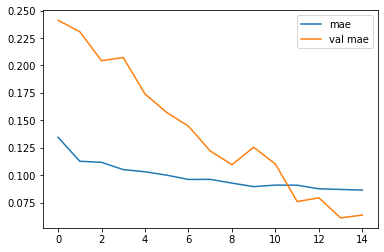

In [49]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
244.09395 1.6924981 293.5527795388761


,actual,prediction
0,14250,14840.483398
1,14250,14813.432617
2,14200,14817.539062
3,14200,14786.931641
4,14200,14787.954102
...,...,...
229,14800,14981.204102
230,14750,14934.833984
231,15250,14956.618164
232,14350,14914.555664


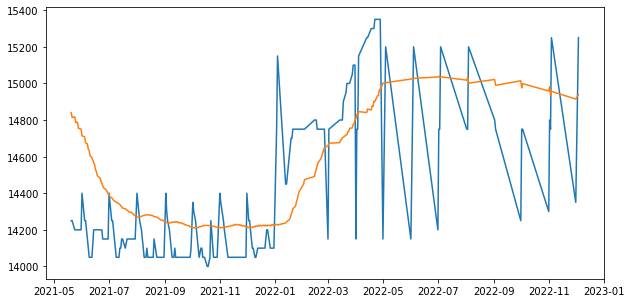

In [50]:
prediction1_a1 = forecast_predict(model1_a, test_gulpas_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_gulpas1_a1 = pd.DataFrame()
data_new_gulpas1_a1['actual'] = x_test
data_new_gulpas1_a1['prediction'] = data_result1_a1
data_new_gulpas1_a1.to_csv('gulpas_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas1_a1.actual)
plt.plot(y_test, data_new_gulpas1_a1.prediction)
data_new_gulpas1_a1

#### Type 3

In [51]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0313 - mae: 0.1123 - mape: 2208174.7500 - val_loss: 0.0052 - val_mae: 0.0670 - val_mape: 13024752.0000
Epoch 2/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0312 - mae: 0.1148 - mape: 2256747.2500 - val_loss: 0.0046 - val_mae: 0.0626 - val_mape: 12539970.0000
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0311 - mae: 0.1139 - mape: 2233141.2500 - val_loss: 0.0050 - val_mae: 0.0658 - val_mape: 12896687.0000
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0310 - mae: 0.1149 - mape: 2276852.0000 - val_loss: 0.0051 - val_mae: 0.0661 - val_mape: 12930570.0000
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0309 - mae: 0.1144 - mape: 2237352.7500 - val_loss: 0.0046 - val_mae: 0.0625 - val_mape: 12526170.0000
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0308 - mae: 0.1119 - mape: 2145853.

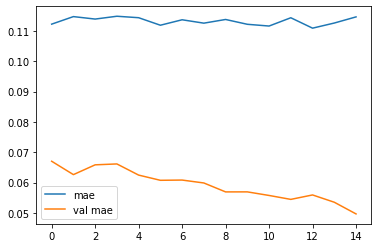

In [52]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
241.35025 1.6757177 300.07711248527437


,actual,prediction
0,14250,14899.448242
1,14250,14869.293945
2,14200,14873.513672
3,14200,14839.295898
4,14200,14839.666016
...,...,...
229,14800,15057.300781
230,14750,15005.223633
231,15250,15030.110352
232,14350,14982.580078


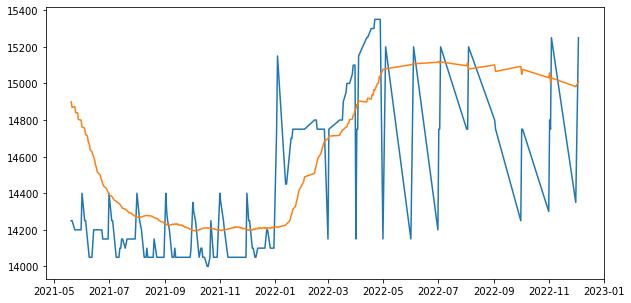

In [53]:
prediction1_a2 = forecast_predict(model1_a, test_gulpas_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_gulpas1_a2 = pd.DataFrame()
data_new_gulpas1_a2['actual'] = x_test
data_new_gulpas1_a2['prediction'] = data_result1_a2
data_new_gulpas1_a2.to_csv('gulpas_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas1_a2.actual)
plt.plot(y_test, data_new_gulpas1_a2.prediction)

data_new_gulpas1_a2

## model 2

### SGD

In [54]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [55]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [56]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 33ms/step - loss: 0.2450 - mae: 0.4193 - mape: 91.0356 - val_loss: 6.7479e-04 - val_mae: 0.0172 - val_mape: 6186989.5000
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1932 - mae: 0.3523 - mape: 71.6290 - val_loss: 0.0044 - val_mae: 0.0610 - val_mape: 12277478.0000
Epoch 3/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1547 - mae: 0.2928 - mape: 54.3022 - val_loss: 0.0129 - val_mae: 0.1106 - val_mape: 17630896.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.1268 - mae: 0.2447 - mape: 41.2951 - val_loss: 0.0241 - val_mae: 0.1530 - val_mape: 22215916.0000
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.1075 - mae: 0.2097 - mape: 32.5582 - val_loss: 0.0366 - val_mae: 0.1897 - val_mape: 26187132.0000
Epoch 6/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0938 - mae: 0.1947 - mape: 31.1944 - val_loss: 0.0482 - v

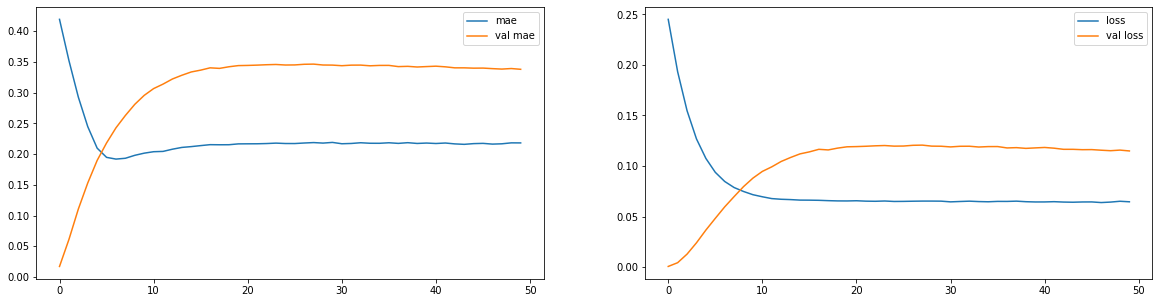

In [57]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
946.04803 6.6530256 1015.0517843932889


,actual,prediction
0,14250,15405.347656
1,14250,15406.115234
2,14200,15403.763672
3,14200,15402.527344
4,14200,15399.751953
...,...,...
229,14800,15408.461914
230,14750,15407.921875
231,15250,15406.461914
232,14350,15405.221680


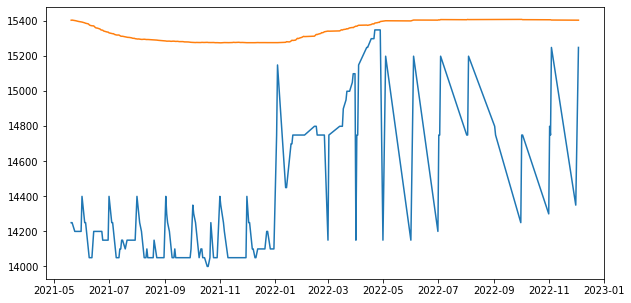

In [58]:
prediction2 = forecast_predict(model2, test_gulpas_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_gulpas2 = pd.DataFrame()
data_new_gulpas2['actual'] = x_test
data_new_gulpas2['prediction'] = data_result2
data_new_gulpas2.to_csv('gulpas_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_gulpas2.actual)
plt.plot(y_test, data_new_gulpas2.prediction)
data_new_gulpas2

#### Type2

In [59]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0431 - mae: 0.1452 - mape: 3126950.7500 - val_loss: 0.0484 - val_mae: 0.2185 - val_mape: 29295526.0000
Epoch 2/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0344 - mae: 0.1159 - mape: 2610816.5000 - val_loss: 0.0430 - val_mae: 0.2058 - val_mape: 27923432.0000
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0326 - mae: 0.1113 - mape: 2390213.5000 - val_loss: 0.0407 - val_mae: 0.2001 - val_mape: 27304884.0000
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0314 - mae: 0.1097 - mape: 2373819.2500 - val_loss: 0.0353 - val_mae: 0.1862 - val_mape: 25792890.0000
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0294 - mae: 0.1056 - mape: 2188925.7500 - val_loss: 0.0301 - val_mae: 0.1715 - val_mape: 24203766.0000
Epoch 6/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0279 - mae: 0.1036 - mape: 21

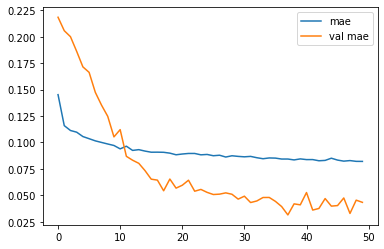

In [60]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [61]:
prediction2_1 = forecast_predict(model2, test_gulpas_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_gulpas2_1 = pd.DataFrame()
data_new_gulpas2_1['actual'] = x_test
data_new_gulpas2_1['prediction'] = data_result2_1
data_new_gulpas2_1.to_csv('gulpas_model3_sgd_type2.csv')

data_new_gulpas2

199/199 [==============================] - 1s 4ms/step
260.40775 1.8136669 330.7224454697625


,actual,prediction
0,14250,15405.347656
1,14250,15406.115234
2,14200,15403.763672
3,14200,15402.527344
4,14200,15399.751953
...,...,...
229,14800,15408.461914
230,14750,15407.921875
231,15250,15406.461914
232,14350,15405.221680


#### Type 3

In [62]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0300 - mae: 0.1093 - mape: 2159516.7500 - val_loss: 0.0028 - val_mae: 0.0464 - val_mape: 10807920.0000
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0293 - mae: 0.1090 - mape: 2172946.7500 - val_loss: 0.0026 - val_mae: 0.0440 - val_mape: 10524381.0000
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0291 - mae: 0.1082 - mape: 2201588.2500 - val_loss: 0.0026 - val_mae: 0.0448 - val_mape: 10619856.0000
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0293 - mae: 0.1102 - mape: 2217765.2500 - val_loss: 0.0023 - val_mae: 0.0417 - val_mape: 10242202.0000
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0285 - mae: 0.1055 - mape: 2059224.2500 - val_loss: 0.0022 - val_mae: 0.0405 - val_mape: 10095686.0000
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0289 - mae: 0.1071 - mape: 2105845.

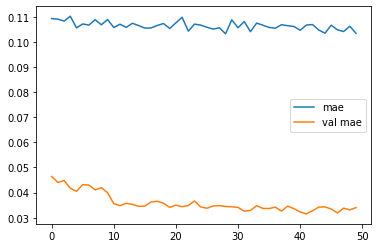

In [63]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [64]:
prediction2_2 = forecast_predict(model2, test_gulpas_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_gulpas2_2 = pd.DataFrame()
data_new_gulpas2_2['actual'] = x_test
data_new_gulpas2_2['prediction'] = data_result2_2
data_new_gulpas2_2.to_csv('gulpas_model3_sgd-type3.csv')

data_new_gulpas2_2

181/181 [==============================] - 1s 4ms/step
206.71501 1.4394431 291.0940032875978


,actual,prediction
0,14250,14908.546875
1,14250,14878.559570
2,14200,14849.353516
3,14200,14827.133789
4,14200,14835.381836
...,...,...
229,14800,15165.445312
230,14750,15114.548828
231,15250,15123.573242
232,14350,15119.347656


### Adam

In [65]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [66]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 35ms/step - loss: 0.1780 - mae: 0.3219 - mape: 62.8680 - val_loss: 0.0023 - val_mae: 0.0419 - val_mape: 9891530.0000
Epoch 2/50
44/44 [==============================] - 1s 19ms/step - loss: 0.0853 - mae: 0.2250 - mape: 51.3050 - val_loss: 0.0094 - val_mae: 0.0936 - val_mape: 15513261.0000
Epoch 3/50
44/44 [==============================] - 1s 23ms/step - loss: 0.0746 - mae: 0.2131 - mape: 49.7400 - val_loss: 0.0121 - val_mae: 0.1072 - val_mape: 17018658.0000
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0723 - mae: 0.2110 - mape: 49.8969 - val_loss: 0.0156 - val_mae: 0.1226 - val_mape: 18713508.0000
Epoch 5/50
44/44 [==============================] - 1s 19ms/step - loss: 0.0699 - mae: 0.2086 - mape: 49.9276 - val_loss: 0.0191 - val_mae: 0.1361 - val_mape: 20197290.0000
Epoch 6/50
44/44 [==============================] - 1s 23ms/step - loss: 0.0678 - mae: 0.2048 - mape: 48.7725 - val_loss: 0.0219 - val_m

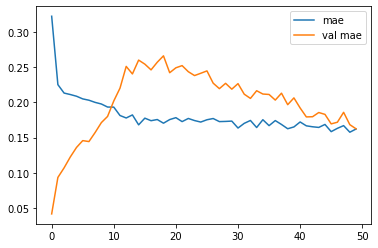

In [67]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [68]:
prediction2_a = forecast_predict(model2_a, test_gulpas_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_gulpas2_a = pd.DataFrame()
data_new_gulpas2_a['actual'] = x_test
data_new_gulpas2_a['prediction'] = data_result2_a
data_new_gulpas2_a.to_csv('gulpas_model3_adam-type1.csv')

data_new_gulpas2_a

131/131 [==============================] - 1s 7ms/step
536.23303 3.7601476 588.4771660820834


,actual,prediction
0,14250,14847.465820
1,14250,14854.688477
2,14200,14798.582031
3,14200,14777.637695
4,14200,14847.098633
...,...,...
229,14800,15575.673828
230,14750,15618.373047
231,15250,15611.421875
232,14350,15609.599609


#### Type 2

In [69]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0200 - mae: 0.0874 - mape: 1768069.1250 - val_loss: 0.0043 - val_mae: 0.0611 - val_mape: 12058285.0000
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0177 - mae: 0.0818 - mape: 1493488.2500 - val_loss: 0.0041 - val_mae: 0.0589 - val_mape: 11853473.0000
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0180 - mae: 0.0794 - mape: 1640776.8750 - val_loss: 9.5761e-04 - val_mae: 0.0232 - val_mape: 7557355.0000
Epoch 4/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0166 - mae: 0.0769 - mape: 1593264.5000 - val_loss: 0.0025 - val_mae: 0.0440 - val_mape: 10336236.0000
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0180 - mae: 0.0799 - mape: 1684845.1250 - val_loss: 0.0021 - val_mae: 0.0393 - val_mape: 9921088.0000
Epoch 6/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0169 - mae: 0.0777 - mape: 

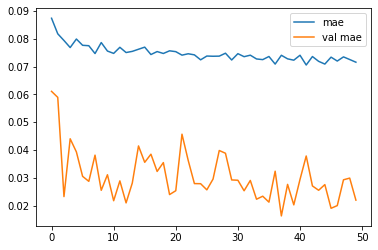

In [70]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
367.90472 2.5606635 578.900520383252


,actual,prediction
0,14250,15673.150391
1,14250,15791.918945
2,14200,15648.664062
3,14200,15472.602539
4,14200,15559.611328
...,...,...
229,14800,15764.937500
230,14750,15837.613281
231,15250,15865.125000
232,14350,15830.975586


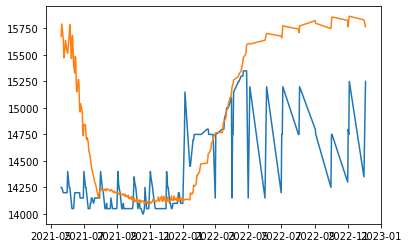

In [71]:
prediction2_a1 = forecast_predict(model2_a, test_gulpas_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_gulpas2_a1 = pd.DataFrame()
data_new_gulpas2_a1['actual'] = x_test
data_new_gulpas2_a1['prediction'] = data_result2_a1
data_new_gulpas2_a1.to_csv('gulpas_model3_adam-type2.csv')

plt.plot(y_test, data_new_gulpas2_a1.actual)
plt.plot(y_test, data_new_gulpas2_a1.prediction)
data_new_gulpas2_a1

#### Type 3

In [72]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0244 - mae: 0.0968 - mape: 1951141.8750 - val_loss: 7.4725e-04 - val_mae: 0.0196 - val_mape: 6852334.5000
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0238 - mae: 0.0953 - mape: 1900708.7500 - val_loss: 8.3949e-04 - val_mae: 0.0216 - val_mape: 7135188.0000
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0235 - mae: 0.0948 - mape: 1797741.3750 - val_loss: 9.8967e-04 - val_mae: 0.0247 - val_mape: 7523684.5000
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0239 - mae: 0.0973 - mape: 1862219.1250 - val_loss: 9.4700e-04 - val_mae: 0.0239 - val_mape: 7432112.5000
Epoch 5/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0236 - mae: 0.0951 - mape: 1773462.8750 - val_loss: 0.0012 - val_mae: 0.0280 - val_mape: 7897691.5000
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0235 - mae: 0.0949 - map

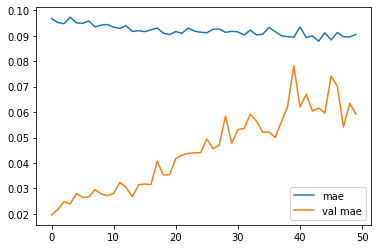

In [73]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
433.91797 3.022874 540.1935706300104


,actual,prediction
0,14250,14657.727539
1,14250,14660.969727
2,14200,14648.762695
3,14200,14644.643555
4,14200,14657.550781
...,...,...
229,14800,16046.588867
230,14750,15972.166992
231,15250,15821.983398
232,14350,15911.144531


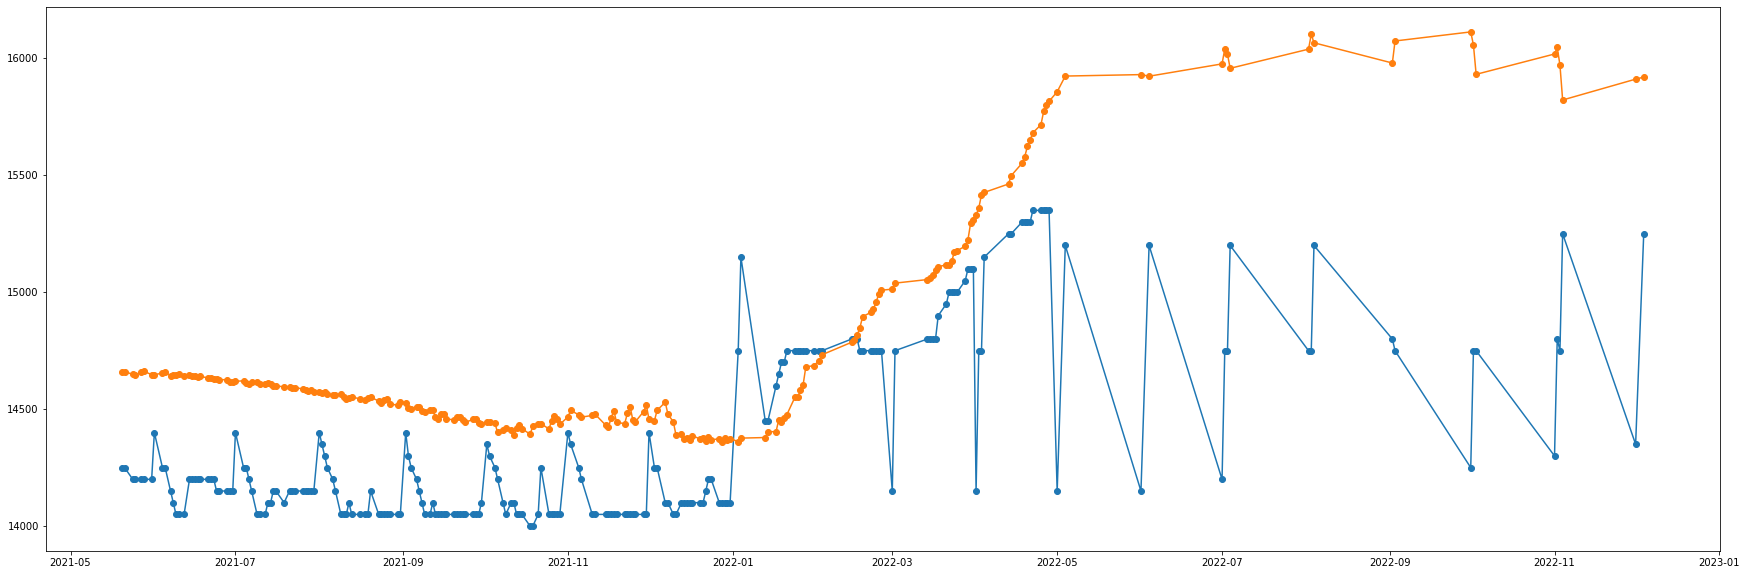

In [74]:
prediction2_a2 = forecast_predict(model2_a, test_gulpas_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_gulpas2_a2 = pd.DataFrame()
data_new_gulpas2_a2['actual'] = x_test
data_new_gulpas2_a2['prediction'] = data_result2_a2
data_new_gulpas2_a2.to_csv('gulpas_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_gulpas2_a2.actual, '-o')
plt.plot(y_test,data_new_gulpas2_a2.prediction, '-o')
data_new_gulpas2_a2